In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
def build_phase_kspace(phase_idx: int,
                       data_dir: Path,
                       nBH: int = 2):
    """
    Assemble combined k-space for one cardiac phase by merging nBH breath holds.
    
    Returns:
      kspace_phase_c: np.ndarray shaped (nCha, nCol, nLin, nPar)
      mask_phase:     np.ndarray shaped (nLin, nPar), boolean sampling mask
    """
    # --- dims & metadata ---
    diminfo = np.fromfile(data_dir / "u_DimInfo.raw", dtype=np.uint32)
    nCol, nLin, nPar, nPhs, nCha = diminfo[:5]

    readout_array = []
    readout_info  = []
    for b in range(nBH):
        ra = np.fromfile(data_dir / f"u_readoutarray_{b}.raw", dtype=np.uint32)
        ri = np.fromfile(data_dir / f"ri_ReadoutInfoData_{b}.raw", dtype=np.int64).reshape(-1,5)
        readout_array.append(ra)
        readout_info.append(ri)

    # --- load complex streams ---
    def load_complex(path):
        rawf = np.fromfile(path, dtype=np.float32)
        return rawf.view(np.complex64)
    
    kspace_stream = []
    for b in range(nBH):
        ks = load_complex(data_dir / f"cf_kspace_{b}.raw")
        kspace_stream.append(ks)

    # --- build each BH volume ---
    kspace_b = [
        np.zeros((nCol, nLin, nPar, nCha), dtype=np.complex64)
        for _ in range(nBH)
    ]
    for b in range(nBH):
        ra = readout_array[b]
        ri = readout_info[b]
        ks = kspace_stream[b]

        # how many readouts for this phase
        n_reads    = ra[phase_idx]
        base_reads = ra[:phase_idx].sum()
        
        for i in range(n_reads):
            ky, kz = ri[base_reads + i, :2]
            for c in range(nCha):
                # compute offset into 1D stream
                offset = (base_reads * nCha + c*n_reads + i) * nCol
                seg    = ks[offset : offset + nCol]
                # where to place
                kspace_b[b][:, ky, kz, c] = seg

    # --- merge BHs by first-wins union ---
    kspace_phase = kspace_b[0].copy()
    for b in range(1, nBH):
        zero_locs = (np.abs(kspace_phase) == 0)
        kspace_phase[zero_locs] = kspace_b[b][zero_locs]

    return kspace_phase

In [7]:
data_dir = Path("./data")
# discover nPhs(number of phases) from the diminfo file
diminfo = np.fromfile(data_dir / "u_DimInfo.raw", dtype=np.uint32)
nPhs = int(diminfo[3])
nBH = int(diminfo[5])

all_kspaces = []
all_masks   = []

for ph in range(nPhs):
    ksp_ph = build_phase_kspace(phase_idx=ph, data_dir=data_dir, nBH=nBH)
    all_kspaces.append(ksp_ph)  # each is (nCol, nLin, nPar, nCha)

# Stack into single arrays:
# ksp: (nPhs, nCha, nCol, nLin, nPar)
ksp_all_phases  = np.stack(all_kspaces, axis=0)
# np.save('ksp_all_phases', ksp_all_phases)

In [11]:
# load coil sensitivity map
csm_path = data_dir / "cf_coil_sensitivity_AVG_0.raw"
raw = np.fromfile(csm_path, dtype=np.float32)
if len(raw)%2:
    print(f"Warning: odd float count in {csm_path.name}")
cplx = raw.view(np.complex64)
csm = cplx.reshape(ksp_all_phases[0].shape, order='F')  # (kx,ky,kz,coils)
sens_map = np.moveaxis(csm, -1, 0)  
sens_map = np.flip(np.flip(np.flip(sens_map, axis=1), axis=2), axis=3)

ss = np.sqrt(np.sum(np.abs(sens_map)**2, axis=0)) + 1e-8
sens_map /= ss

print("sens_map:", sens_map.shape, "mean|∑|S|²-1|=", np.mean(np.abs(np.sum(np.abs(sens_map)**2,0)-1)))

sens_map: (24, 160, 128, 72) mean|∑|S|²-1|= 8.768637e-08


In [14]:
# move phase to first dimension and coil to second dimension - P, C, X, Y, Z

ksp_all_phases_c = np.array([np.moveaxis(i, -1, 0) for i in ksp_all_phases])
print(ksp_all_phases_c.shape)

(20, 24, 160, 128, 72)


In [18]:
# --- sanity on shapes/dtypes (adjust if yours differ) ---
P, C, X, Y, Z = ksp_all_phases_c.shape

# --- build Ω: acquired if any nonzero along coils & readout ---
omega = (np.abs(ksp_all_phases_c).sum(axis=(1, 2)) > 0).astype(np.uint8)   # (P, Y, Z)

# --- quick diagnostics ---
frac_per_phase = omega.reshape(P, -1).mean(axis=1)          # fraction of Ω per phase
print(f"P={P}, C={C}, X={X}, Y={Y}, Z={Z}")
print(f"Ω fraction per phase (mean±sd): {frac_per_phase.mean():.3f} ± {frac_per_phase.std():.3f}")
print(f"Any empty phases? {np.any(frac_per_phase == 0.0)}")

P=20, C=24, X=160, Y=128, Z=72
Ω fraction per phase (mean±sd): 0.035 ± 0.000
Any empty phases? False


In [19]:
def split_theta_lam_val_from_omega(omega: np.ndarray, split_seed: int = 13,
                                   ratios=(0.6, 0.2, 0.2)):
    """
    omega: (P, Y, Z) bool/uint8 acquired grid per phase
    returns: theta, lam, val (each (P, Y, Z) bool)
    """
    assert abs(sum(ratios) - 1.0) < 1e-8, "ratios must sum to 1"
    P, Y, Z = omega.shape
    theta = np.zeros((P, Y, Z), dtype=bool)
    lam   = np.zeros((P, Y, Z), dtype=bool)
    val   = np.zeros((P, Y, Z), dtype=bool)

    rng = np.random.default_rng(split_seed)

    for p in range(P):
        mask_p = omega[p].astype(bool)
        flat_idx = np.flatnonzero(mask_p.ravel())
        n = flat_idx.size
        if n == 0:
            continue

        rng.shuffle(flat_idx)

        n1 = int(np.floor(ratios[0] * n))  # Θ
        n2 = int(np.floor(ratios[1] * n))  # Λ
        # ensure all three subsets get something when feasible
        if n >= 3:
            n1 = max(1, n1)
            n2 = max(1, n2)
            if n1 + n2 >= n:
                # pull back to leave at least 1 for Val
                take = (n1 + n2) - (n - 1)
                # reduce from the larger of n1/n2
                if n1 >= n2:
                    n1 -= take
                else:
                    n2 -= take
                n1 = max(1, n1)
                n2 = max(1, n2)
        cut1 = n1
        cut2 = n1 + n2
        idx_theta, idx_lam, idx_val = np.split(flat_idx, [cut1, cut2])

        # write back
        th = theta[p].ravel(); th[idx_theta] = True
        la = lam[p].ravel();   la[idx_lam]   = True
        va = val[p].ravel();   va[idx_val]   = True

    # ---- diagnostics
    overlap_any = bool(np.any(theta & lam) or np.any(theta & val) or np.any(lam & val))
    cover_all_ok = bool(np.all((theta | lam | val) == omega.astype(bool)))

    # fractions over Ω per phase
    denom = omega.astype(bool).sum(axis=(1, 2)).clip(min=1)  # avoid /0
    frac_theta = (theta & omega.astype(bool)).sum(axis=(1, 2)) / denom
    frac_lam   = (lam   & omega.astype(bool)).sum(axis=(1, 2)) / denom
    frac_val   = (val   & omega.astype(bool)).sum(axis=(1, 2)) / denom

    def ms(x):  # mean±sd string
        return f"{x.mean():.3f}±{x.std(ddof=0):.3f}"

    print("overlap_any:", overlap_any)
    print("cover_all_ok:", cover_all_ok)
    print(f"Θ fraction over Ω (mean±sd): {ms(frac_theta)}")
    print(f"Λ fraction over Ω (mean±sd): {ms(frac_lam)}")
    print(f"Val fraction over Ω (mean±sd): {ms(frac_val)}")

    return theta, lam, val

In [20]:
split_seed = 1337
theta, lam, val = split_theta_lam_val_from_omega(omega, split_seed=split_seed)

overlap_any: False
cover_all_ok: True
Θ fraction over Ω (mean±sd): 0.599±0.001
Λ fraction over Ω (mean±sd): 0.199±0.001
Val fraction over Ω (mean±sd): 0.202±0.002


In [17]:
P, C, X, Y, Z = ksp_all_phases_c.shape
assert sens_map.shape == (C, X, Y, Z), f"sens shape mismatch: {sens_map.shape} vs {(C,X,Y,Z)}"
for name, m in {"omega": omega, "theta": theta, "lam": lam, "val": val}.items():
    assert m.shape == (P, Y, Z), f"{name} mask shape mismatch: {m.shape} vs {(P,Y,Z)}"

# ---- sanity checks (disjoint + cover) ----
overlap_any = np.any(theta & lam) or np.any(theta & val) or np.any(lam & val)
assert not overlap_any, "Masks overlap between Θ/Λ/Val!"

cover_all_ok = np.array_equal((theta | lam | val), omega)
assert cover_all_ok, "Θ ∪ Λ ∪ Val does not equal Ω!"

# fractions (optional log)
frac = lambda m: m.sum(axis=(1,2)) / np.maximum(omega.sum(axis=(1,2)), 1)
print("Θ fraction over Ω (mean±sd): %.3f±%.3f" % (frac(theta).mean(), frac(theta).std()))
print("Λ fraction over Ω (mean±sd): %.3f±%.3f" % (frac(lam).mean(),   frac(lam).std()))
print("Val fraction over Ω (mean±sd): %.3f±%.3f" % (frac(val).mean(), frac(val).std()))

Θ fraction over Ω (mean±sd): 0.599±0.001
Λ fraction over Ω (mean±sd): 0.199±0.001
Val fraction over Ω (mean±sd): 0.202±0.002


In [21]:
save_path = "scan20_splits.npz"
np.savez_compressed(
    save_path,
    ksp = ksp_all_phases_c,                   # (P, C, X, Y, Z) complex64
    sens   = sens_map,                           # (C, X, Y, Z)    complex64
    theta  = theta.astype(np.uint8),             # (P, Y, Z)
    lam    = lam.astype(np.uint8),               # (P, Y, Z)
    val    = val.astype(np.uint8),               # (P, Y, Z)
    omega  = omega.astype(np.uint8),             # (P, Y, Z)
    split_seed = np.int64(split_seed),
)
print(f"Saved → {save_path}")

Saved → scan20_splits.npz


In [79]:
with np.load(save_path, allow_pickle=False) as npz:
    print("Saved keys:", list(npz.keys()))
    print("ksp shape:", npz["ksp"].shape, npz["ksp"].dtype)
    print("sens shape:", npz["sens"].shape, npz["sens"].dtype)
    print("theta/lam/val:", npz["theta"].shape, npz["lam"].shape, npz["val"].shape)
    print("omega:", npz["omega"].shape)
    print("split_seed:", int(npz["split_seed"]))

Saved keys: ['ksp', 'sens', 'theta', 'lam', 'val', 'omega', 'split_seed']
ksp shape: (20, 24, 160, 128, 72) complex64
sens shape: (24, 160, 128, 72) complex64
theta/lam/val: (20, 128, 72) (20, 128, 72) (20, 128, 72)
omega: (20, 128, 72)
split_seed: 1337


In [23]:
# to save mask as png
def make_image(data, outputname, size=(5, 5), dpi=80):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('hot')
    ax.imshow(data, aspect='equal', cmap='Grays_r')
    fig.set_facecolor('#000000')
    plt.savefig(outputname, dpi=dpi)

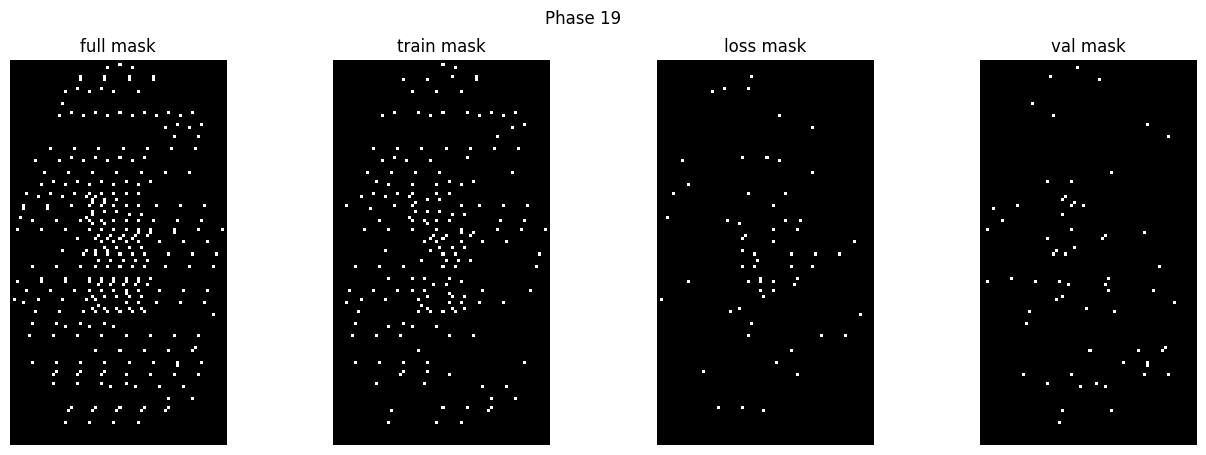

In [78]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16, 5))
p = np.random.randint(20)

fig.suptitle(f'Phase {p}')

undersampled_mask = np.fft.ifftshift(omega[p].astype(bool))
train_mask = np.fft.ifftshift(theta[p])
loss_mask = np.fft.ifftshift(lam[p])
val_mask = np.fft.ifftshift(val[p])

ax1.imshow(undersampled_mask, cmap='gray')
ax1.set_title('full mask')
ax1.set_axis_off()

ax2.imshow(train_mask, cmap='gray')
ax2.set_title('train mask')
ax2.set_axis_off()

ax3.imshow(loss_mask, cmap='gray')
ax3.set_title('loss mask')
ax3.set_axis_off()

ax4.imshow(val_mask, cmap='gray')
ax4.set_title('val mask')
ax4.set_axis_off()

plt.show()